# Morphology: Trees (Notebook)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/docs/source/tutorials/Morphology_trees.ipynb)

This tutorial will guide you through creating a neuronal morphology representation step by step. First, we will read data from an SWC file using the `SWCReader` class. Next, we will use factory functions to create a `PointTree` i.e. the graph-tree representation of our morphological reconstruction. Then, we will split the point tree into sections to obtain a `SectionTree`. Finally, we will build a `SegmentTree` that divides our cell into computational segments for simulation.

<div style="
  border-left: 6px solid #f39c12;
  background-color: #2a2514;
  color: lightgray;
  padding: 12px 16px;
  margin: 16px 0;
  border-radius: 4px;
  width: 95%;
  font-family: 'Segoe UI', sans-serif;
">
  <div style="font-weight: bold; color: #f1c40f; margin-bottom: 4px;">Warning</div>
  Note that for most use cases, you won't need to follow the manual morphology processing described below. You can simply use the <code>load_morphology</code> method of the <code>Model</code> class. Only follow the steps below if the method fails to read the morphology automatically or if you want to manually intervene in the process.
</div>


In [ ]:
!pip install dendrotweaks

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [ ]:
# import os
# os.kill(os.getpid(), 9)

Let's begin by importing the standard libraries and the dendrotweaks library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dendrotweaks as dd
dd.__version__

'0.4.6'

In [3]:
dd.apply_dark_theme() # Set the theme for the plots

In [ ]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

## Reading an SWC file

In [ ]:
path_to_swc_file = os.path.join('examples', 'Park_2019', 'morphology', 'original.swc')
print(f'Path to file: {path_to_swc_file}')

Path to file: examples/Park_2019/morphology/Park_2019.swc


The first step in neuronal morphology analysis is reading the SWC file. DendroTweaks provides a straightforward method to load SWC data into a pandas DataFrame:

In [6]:
from dendrotweaks.morphology.io import SWCReader

In [8]:
reader = SWCReader()

In [10]:
df = reader.read_file(path_to_swc_file)

For initial data exploration, you can use standard pandas operations:

In [12]:
df.head()

,Index,Type,Domain,Color,X,Y,Z,R,Parent
0,1,1,soma,#E69F00,11.621167,104.434833,-6.694167,10.218962,-1
1,2,1,soma,#E69F00,11.621167,94.215871,-6.694167,10.218962,1
2,3,1,soma,#E69F00,11.621167,114.653796,-6.694167,10.218962,1
3,4,2,axon,#F0E442,5.260000,92.000000,-9.100000,0.295000,1
4,5,2,axon,#F0E442,5.290000,91.490000,-9.100000,0.295000,4


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2214 entries, 0 to 2213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   2214 non-null   int64  
 1   Type    2214 non-null   int64  
 2   Domain  2214 non-null   object 
 3   Color   2214 non-null   object 
 4   X       2214 non-null   float64
 5   Y       2214 non-null   float64
 6   Z       2214 non-null   float64
 7   R       2214 non-null   float64
 8   Parent  2214 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 155.8+ KB


## Creating a Point Tree

While the DataFrame provides a convenient way to manipulate data, a tree structure is more suitable for morphological analysis. The `PointTree` class represents a tree structure of neuronal points, with each node containing spatial information. To create a point tree from the DataFrame, use the `create_point_tree` function:

In [16]:
from dendrotweaks.morphology.io import create_point_tree

In [17]:
point_tree = create_point_tree(df)

Once we have the point tree, we can perform various postprocessing steps to refine and standardize the morphological data. We will start by removing overlapping nodes:

In [ ]:
point_tree.remove_overlaps()

### Soma notation

Next, we will check and standardize the soma notation. The soma can be represented in three ways in SWC files:

- Three-point soma: soma represented by three points
- One-point soma: soma represented by a single point
- Contour: set of points defining the soma boundary

NeuroMorpho.org considers the three-point soma notation the standard representation. For more details, see the [Soma format representation in NeuroMorpho.Org](https://neuromorpho.org/SomaFormat.html) 

To check the current soma notation we can use the soma_notation property:

In [18]:
point_tree.soma_notation

'3PS'

We can change the soma notation to the three-point soma using the change_soma_notation method:

In [19]:
point_tree.change_soma_notation('3PS')

### Sorting

We now want to make sure that the nodes are properly sorted. For this we will perform depth-first traversal of the tree and update each node’s index as we visit the node.

In [20]:
point_tree.sort(sort_children=True, force=False)

Sorted PointTree(root=Point(idx=0), num_nodes=2214).


Sorting the trees is performed based on ther topological structure only. That is tree graph traversal is performed depth-first and children are selected in a way that the child with a smaller subtree (in terms of the number of bifurcations in the subtree) is traversed first.
This ensures deterministic traversal and indexing of a neruonal morhology.

### Shifting and aligning the tree

We can also shift the tree to the soma center and align the apical dendrite with the vertical axis.

The `align_apical_dendrite` method should be used only for cells with an apical dendrite. The round_coordinates method rounds the coordinates to the specified number of decimal places.

In [21]:
point_tree.shift_coordinates_to_soma_center()
point_tree.align_apical_dendrite()
point_tree.round_coordinates(8)

Let's now validate the tree structure

In [22]:
from dendrotweaks.morphology.io import validate_tree

The method will automatically detect the tree type and run the required validation steps

In [23]:
validate_tree(point_tree)

Checking for unique node ids...
Checking for unique root node...
Checking for duplicate children...
Checking tree connectivity...
Checking for loops...
Checking for bifurcations with more than 2 children...
Checking for NaN values...
Checking for bifurcations in the soma...
Checking if the tree is sorted...
***Validation complete.***


## Creating a Section Tree

Now we are ready to create a section tree from the point tree. The create_section_tree function splits the point tree into sections based on the bifurcation points:

In [25]:
from dendrotweaks.morphology.io import create_section_tree

In [26]:
sec_tree = create_section_tree(point_tree)

Extended 44 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2258).


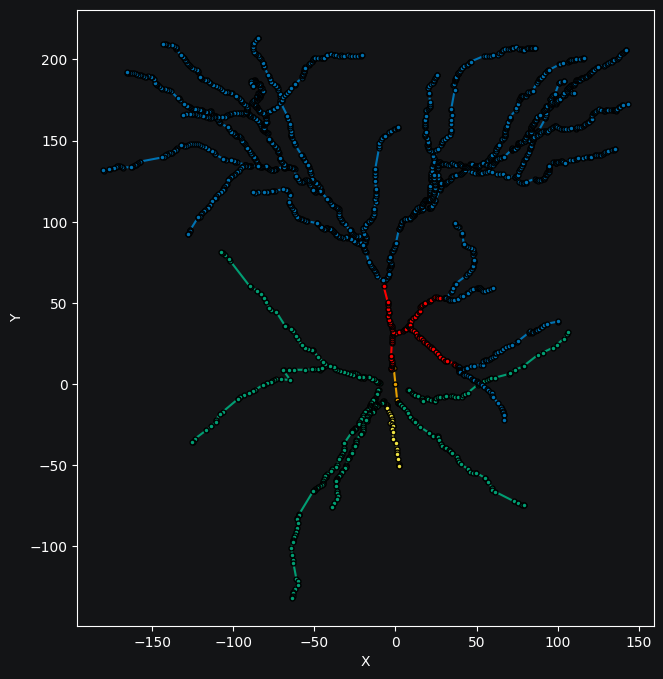

In [ ]:
sections_to_highlight = [
    sec for sec in sec_tree 
    if sec.domain_name == 'apic' and sec.path_distance() < 50
]

fig, ax = plt.subplots(figsize=(8, 8))
sec_tree.plot(
    ax=ax, 
    show_domains=True, 
    show_points=True, 
    show_lines=True, 
    highlight_sections=sections_to_highlight # in red
)

In [50]:
sec_tree.topology()

parent |   idx
---------------
    -1 |   •0
     0 |   ├─•1
     0 |   ├─•2
     0 |   ├─•3
     0 |   ├─•4
     0 |   ├─•5
     0 |   ├─•6
     6 |   │ ├─•7
     6 |   │ └─•8
     0 |   └─•9
     9 |     ├─•10
    10 |     │ ├─•11
    11 |     │ │ ├─•12
    11 |     │ │ └─•13
    10 |     │ └─•14
    14 |     │   ├─•15
    14 |     │   └─•16
     9 |     └─•17
    17 |       ├─•18
    18 |       │ ├─•19
    19 |       │ │ ├─•20
    19 |       │ │ └─•21
    21 |       │ │   ├─•22
    21 |       │ │   └─•23
    23 |       │ │     ├─•24
    23 |       │ │     └─•25
    18 |       │ └─•26
    26 |       │   ├─•27
    26 |       │   └─•28
    28 |       │     ├─•29
    28 |       │     └─•30
    30 |       │       ├─•31
    30 |       │       └─•32
    17 |       └─•33
    33 |         ├─•34
    34 |         │ ├─•35
    34 |         │ └─•36
    33 |         └─•37
    37 |           ├─•38
    37 |           └─•39
    39 |             ├─•40
    40 |             │ ├─•41
    40 |             

In [34]:
validate_tree(point_tree)

Checking for unique node ids...
Checking for unique root node...
Checking for duplicate children...
Checking tree connectivity...
Checking for loops...
Checking for bifurcations with more than 2 children...
Checking for NaN values...
Checking for bifurcations in the soma...
Checking the extended tree for geometric continuity...
Checking if the tree is sorted...
***Validation complete.***


## Creating domains

In [36]:
from dendrotweaks.morphology.io import create_domains

In [37]:
domains = create_domains(sec_tree)

In [38]:
domains

{'apic': <Domain(apic, 4, #0072B2, 43 sections)>,
 'axon': <Domain(axon, 2, #F0E442, 1 sections)>,
 'dend': <Domain(dend, 3, #019E73, 7 sections)>,
 'soma': <Domain(soma, 1, #E69F00, 1 sections)>}

## Creating a Segment Tree

In [44]:
from dendrotweaks.morphology.io import create_segment_tree
from dendrotweaks.utils import calculate_lambda_f

In [41]:
for sec in sec_tree.sections:
    sec.create_and_reference()

In [ ]:
d_lambda = 0.1
f = 100

for sec in sec_tree.sections:
    lambda_f = calculate_lambda_f(sec.distances, sec.diameters, sec.Ra, sec.cm, f)
    nseg = max(1, int((sec.L / (d_lambda * lambda_f) + 0.9) / 2) * 2 + 1)
    sec._nseg = sec._ref.nseg = nseg

In [47]:
seg_tree = create_segment_tree(sec_tree)

In [49]:
validate_tree(seg_tree)

Checking for unique node ids...
Checking for unique root node...
Checking for duplicate children...
Checking tree connectivity...
Checking for loops...
Checking for bifurcations with more than 2 children...
Checking if the tree is sorted...
***Validation complete.***
